In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from ipywidgets import interact
import ipywidgets as widgets

from tqdm import tqdm_notebook

import networkx as nx

In [2]:
df = pd.read_csv('2_clean_lines.csv')

In [3]:
df.head()

,title,character,lines,season,episode,length
0,The One Where Monica Gets a New Roommate (The ...,monica,There's nothing to tell! He's just some guy I ...,1,1,single
1,The One Where Monica Gets a New Roommate (The ...,joey,"C'mon, you're going out with the guy! There's ...",1,1,single
2,The One Where Monica Gets a New Roommate (The ...,chandler,So does he have a hump? A hump and a hairpiece?,1,1,single
3,The One Where Monica Gets a New Roommate (The ...,phoebe,"Wait, does he eat chalk?",1,1,single
4,The One Where Monica Gets a New Roommate (The ...,phoebe,"Just, 'cause, I don't want her to go through w...",1,1,single


In [4]:
df.shape

(58405, 6)

In [5]:
df.isna().sum()

title         0
character     0
lines        23
season        0
episode       0
length        0
dtype: int64

In [6]:
#drop NA as these are empty (character only has directions, but doesn't say anything)
df = df.dropna()

In [7]:
df.shape

(58382, 6)

### Initial EDA

In [8]:
print('Seasons: ', df.season.unique())
print('Average Number Episodes by Season: ', df.groupby('season')['episode'].max().mean())
print('Total Lines: ', df.shape[0])

Seasons:  [ 1  2  3  4  5  6  7  8  9 10]
Average Number Episodes by Season:  22.9
Total Lines:  58382


In [9]:
#double length episode have approximately twice as many lines
df.groupby(['season', 'length']).mean()

episode
season length           
1      single  12.642414
2      double  12.000000
       single  12.924935
3      single  13.206616
4      double  23.000000
       single  11.741857
5      double  23.000000
       single  11.898138
6      double  19.537815
       single  11.827620
7      double  23.000000
       single  11.519039
8      double  23.000000
       single  11.122058
9      double  23.000000
       single  12.025444
10     double  17.000000
       single   8.436804

#### Total number of lines by season

* **The number of lines per season decreases as the seasons increase**

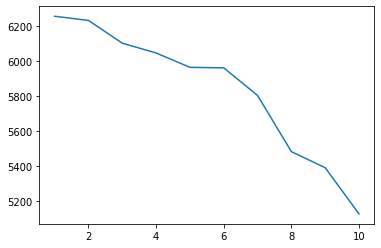

In [10]:
#number of lines by season
sns.lineplot(x = df.season.unique(), y = df.season.value_counts().to_list());

As the length of episodes stayed the same (22-23 minutes), possible explanations I have come up with for this are:
* The number of episodes by season decreased
* When the TV show first aired many characters were introduced and as the seasons went on and the main character became more developed there was less need/ interest for additional characters

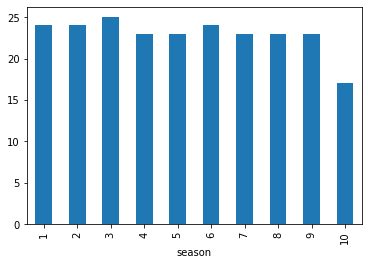

In [11]:
#There are less episodes as the seasons continue
df.groupby('season')['episode'].max().plot(kind = 'bar');

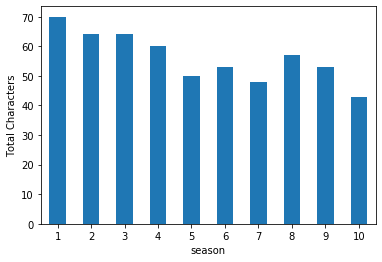

In [12]:
#Barplot of unique characters by season
df.groupby('season')['character'].nunique().plot(kind = 'bar')
plt.xticks(rotation=0)
plt.ylabel("Total Characters")
plt.show()

#### Total number of lines by main character

In [13]:
#list of the main characters
main_characters = ['monica', 'rachel', 'chandler', 'ross', 'phoebe', 'joey']

In [14]:
#instantiate an empty dictionary
total_line_dic = {}

#fill in dictionary of character lines
for char in df['character'].unique():
    if char in main_characters:
        total_line_dic[char] = df[df['character'] == char]['character'].value_counts()

* **Rachel has the most lines**
* **Phoebe has the least lines**

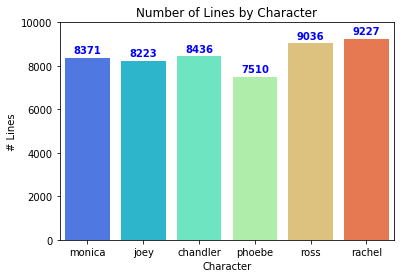

In [15]:
#total lines by main character
fig, ax = plt.subplots()
sns.countplot(x=df[df['character'].isin(main_characters)]['character'], data=df, palette = 'rainbow')

for i, v in enumerate(np.round(list(total_line_dic.values()), 2)):
    ax.text(i - 0.25, v+210, str(v[0]), color='blue', fontweight='bold')
    
ax.set_ylim(0,10000)
ax.set_xlabel('Character')
ax.set_ylabel('# Lines')
plt.title('Number of Lines by Character')

plt.savefig('1 Number of Lines by Character')
plt.show()

#### Number of lines by main character by season

##### Line chart

In [16]:
#dataframe of main characters only
main = df[df['character'].isin(main_characters)].reset_index(drop = True)

#create groupby by season and characters
group = main.groupby(['season', 'character']).count()

#reset index
main_group = group.T.reset_index().T.reset_index()[1:]

* Phoebe consistently has the least lines <br>
* Chandler has very few lines in season 8 <br>
* Joey's lines increase as the seasons go on - maybe he became a more popular character?

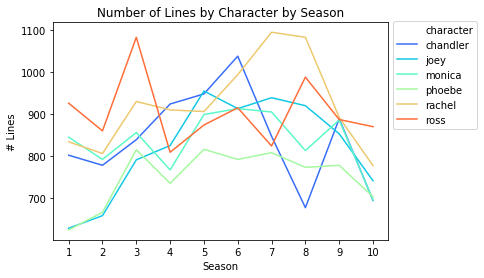

In [17]:
#lines by characters by season
fig, ax = plt.subplots()
sns.lineplot(x = main_group['season'].tolist(), y = main_group[0].astype(int), 
             hue = 'character', data = main_group, ax = ax, palette = 'rainbow')
# font = {'family': 'serif',
#         'color':  'darkred',
#         'weight': 'normal',
#         'size': 16,
#         }

ax.legend(bbox_to_anchor=(1., 1.03))
ax.set_xlabel('Season')

plt.xticks(np.arange(1, 10+1, step=1))

ax.set_ylabel('# Lines')
plt.title('Number of Lines by Character by Season')

plt.savefig('2 Number of lines by character by season')
plt.show();

##### Bar chart with slider

In [18]:
def f(x):
    """
    Creates a barplot that you can for the number of lines by character by season.
    You can use the slider to select a season
    """

    fig, ax = plt.subplots()
    ax.set_ylim(0,1200)
    
    df_season = df[df['season'] == x]
    
    season_line_dic = {}
        
    for char in df_season['character'].unique():
        if char in main_characters:
            season_line_dic[char] = df_season[df_season['character'] == char]['character'].value_counts()
        
    for i, v in enumerate(np.round(list(season_line_dic.values()), 2)):
        ax.text(i - 0.15, v + 25, str(v[0]), color='blue', fontweight='bold')
    
    print('Most lines:', df_season[df_season['character'].isin(main_characters)]['character'].value_counts().idxmax())
    print('No. Lines:', df_season[df_season['character'].isin(main_characters)]['character'].value_counts().max())
    
    sns.countplot(x = df_season[df_season['character'].isin(main_characters)]['character'], data=df_season, palette = 'rainbow');
    

In [19]:
#create a slider to slide through seasons
interact(f, x=widgets.IntSlider(min=main.season.min(), max=main.season.max(), step=1, value=10, 
                                description = 'Season'));

interactive(children=(IntSlider(value=10, description='Season', max=10, min=1), Output()), _dom_classes=('widg…

#### Average lines per episode by season

In [20]:
group = df.groupby(['season', main.character]).mean()

In [21]:
#create episode groupby to insert into line chart
episode_group = main.groupby(['season', 'character']).mean()
episode_group = episode_group.T.reset_index().T.reset_index()[1:]

Overall average: 12.321968694743171


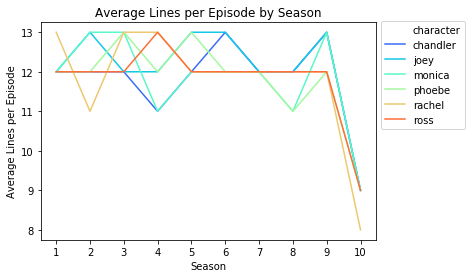

In [22]:
#creates line plot that shows average lines per episode per season
fig, ax = plt.subplots()
sns.lineplot(x = episode_group['season'].tolist(), y = episode_group[0].astype(int), 
             hue = 'character', data = episode_group, ax = ax, palette = 'rainbow')
ax.legend(bbox_to_anchor=(1., 1.03))
plt.xticks(np.arange(1, 10+1, step=1))
ax.set_xlabel('Season')
ax.set_ylabel('Average Lines per Episode')
plt.title('Average Lines per Episode by Season')
print("Overall average:", episode_group[0].mean())
plt.savefig('3 Average lines per episode by season')
plt.show()

#### Line length by character

In [23]:
#add column with line length
df['len_lines'] = df.lines.map(lambda x: len(x.split()))
df.sort_values('len_lines', ascending = False).head()

#pd.set_option('display.max_colwidth', -1)

,title,character,lines,season,episode,length,len_lines
45731,The One In Massapequa,monica,"No, no it’s going to be great. Really! Mom, Da...",8,18,single,196
26936,The One With Rachel's Inappropriate Kiss,rachel,Now you're probably going to hire one of the p...,5,17,single,173
3121,The One With the Candy Hearts,ross,"No, it's just...you know the whole ""getting on...",1,14,single,148
37,The One Where Monica Gets a New Roommate (The ...,rachel,"Oh God... well, it started about a half hour b...",1,1,single,147
26501,The One With The Girl Who Hits Joey,phoebe,"All right, everyone calm down! Everyone calm d...",5,15,single,146


* **Phoebe has the longest lines on average**
* **Monica has the shortest lines**

In [24]:
#create a dataframe of average line length by character
len_dic = {}
for char in df['character'].unique():
    if char in main_characters:
        len_dic[char] = df[df['character'] == char].len_lines.mean()
len_line = pd.DataFrame(len_dic, index = range(0,5)).T[0]

In [25]:
len_line

monica       9.698124
joey        10.456524
chandler     9.985894
phoebe      10.614514
ross        10.279327
rachel      10.357863
Name: 0, dtype: float64

In [26]:
order = ['monica', 'joey', 'chandler', 'phoebe', 'ross', 'rachel']

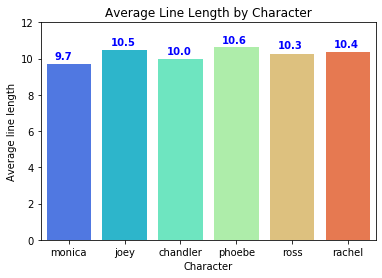

In [27]:
#average line length by character
fig, ax = plt.subplots()

sns.barplot(x = order , y = pd.DataFrame(len_dic, index = range(0,5)).iloc[0], 
          palette = 'rainbow', ax = ax)
for i, v in enumerate(np.round(list(len_dic.values()), 1)):
    ax.text(i-0.25 , v+0.25, str(v), color='blue', fontweight='bold')

    
plt.title('Average Line Length by Character')    
ax.set_ylabel('Average line length')
ax.set_xlabel('Character')
ax.set_ylim(0,12)

plt.savefig('Average Line Length by Character')
plt.show()

In [28]:
pd.set_option('display.max_colwidth', -1)
df[(df['character'] == 'phoebe') & (df['len_lines'] > 20)][:5]

,title,character,lines,season,episode,length,len_lines
188,The One Where Monica Gets a New Roommate (The Pilot),phoebe,"You're welcome. I remember when I first came to this city. I was fourteen. My mom had just killed herself and my step-dad was back in prison, and I got here, and I didn't know anybody. And I ended up living with this albino guy who was, like, cleaning windows outside port authority, and then he killed himself, and then I found aromatherapy. So believe me, I know exactly how you feel.",1,1,single,72
265,The One With the Sonogram at the End,phoebe,"Monica- Hi! Um, Monica, you're scaring me. I mean, you're like, you're like all chaotic and twirly. And not-not in a good way.",1,2,single,23
455,The One With the Sonogram at the End,phoebe,"You know, if you tilt your head to the left, and relax your eyes, it kinda looks like an old potato.",1,2,single,21
519,The One With the Thumb,phoebe,"Okay. Okay, let's say I bought a really great pair of shoes. Do you know what I'd hear, with every step I took? 'Not-mine. Not-mine. Not-mine.' And even if I was happy, okay, and, and skipping- 'Not-not-mine, not-not-mine, not-not-mine, not-not-mine'...",1,3,single,40
552,The One With the Thumb,phoebe,"'Dear Ms. Buffay. Thank you for calling attention to our error. We have credited your account with five hundred dollars. We're sorry for the inconvenience, and hope you'll accept this- -football phone as our free gift.' Do you believe this?! Now I have a thousand dollars, and a football phone!",1,3,single,50


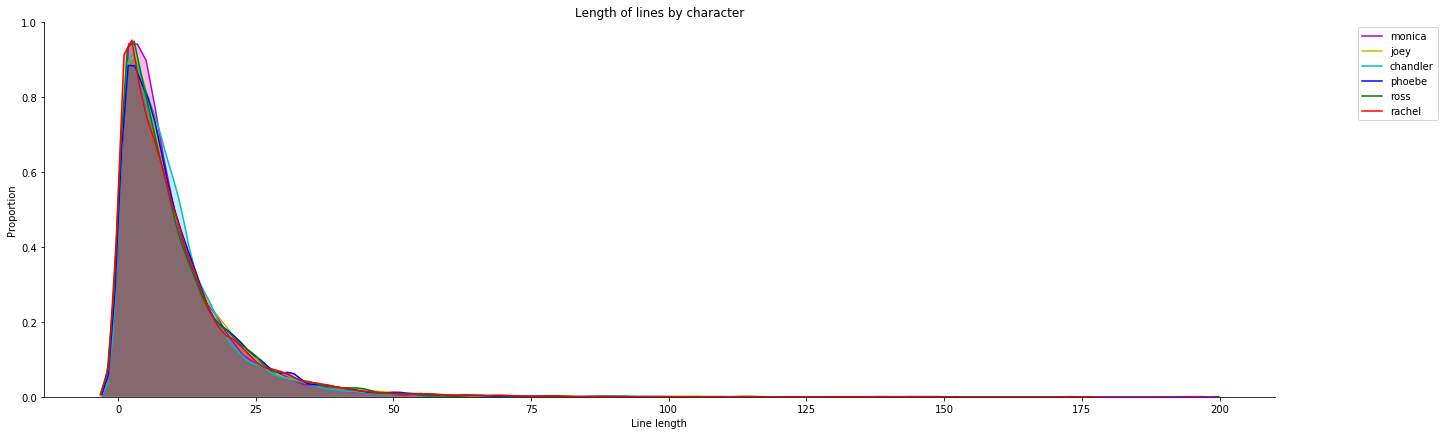

In [29]:
#distribution plot line length by character
g = sns.pairplot(data=df[df['character'].isin(main_characters)], x_vars=['len_lines',], y_vars=['len_lines',],
             hue='character', height=6, aspect = 3,
             palette = {"rachel" : 'r', 'phoebe': 'b','ross': 'g', 'chandler': 'c', 'monica': 'm', 'joey': 'y' })
plt.legend(loc='upper center', bbox_to_anchor=(1.10, 1.0), ncol=1)

g.axes[0][0].set_xlabel('Line length')
g.axes[0][0].set_ylabel('Proportion')
g._legend.set_visible(False)
plt.title('Length of lines by character')

plt.show()

#### Other characters

##### General

There are a total of 339 characters in Friends

In [30]:
df.character.nunique()

339

87% of lines are by main characters

In [31]:
#Proportion of lines by main characters
df[df.character.isin (main_characters)].shape[0]/df.shape[0]

0.8701825905244768

##### Secondary characters (100 - 1000 lines)

After the main characters, Mike has the most lines <br /> 
Many of the secondary character are family members or love interests

In [32]:
secondary_characters = df.character.value_counts()[(df.character.value_counts().values > 100) & 
                            (df.character.value_counts().values < 1000)].keys()

In [33]:
def line_count(character, x, y):
    """Creates a plot that shows the number of lines by character"""
    
    fig, ax = plt.subplots(figsize = (20,5))
    sns.countplot(x=df[df['character'].isin(character)]['character'], data=df, palette = 'rainbow',
                 order = df[df['character'].isin(character)]['character'].value_counts().index)
    
    ax.set_ylim(0,df[df['character'].isin(character)].character.value_counts().max() + x)
    ax.set_ylabel('Number of lines')
    ax.set_xlabel('Character')
    plt.title('Number of lines of {} characters'.format(y))
    
    plt.savefig('4 Number of lines of secondary characters')
    plt.show()

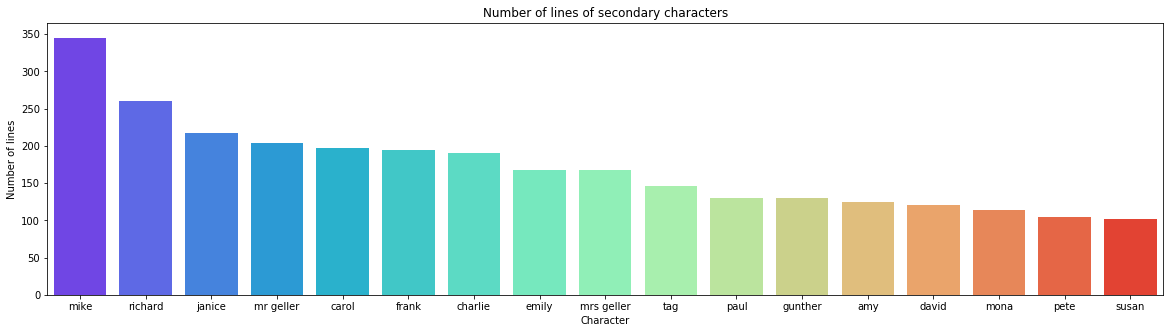

In [34]:
line_count(secondary_characters, 20, 'secondary')

In [35]:
def char_lines(person):
    """ A plot that outlines the number of lines for a specific character across seasons"""
    fig, ax = plt.subplots()
    name = df[df['character'] == person]
    sns.countplot(name.season, palette = 'rainbow', ax = ax)
    ax.set_ylabel('Number of lines')
    ax.set_xlabel('Season')
    plt.title("{}'s number of lines by season".format(person))
    plt.show();

Phoebe dates Mike from Season 9, the Mike before is referring to other characters that are also called Mike

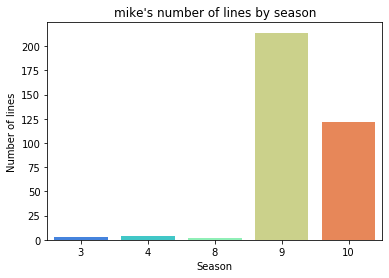

In [36]:
char_lines('mike')

Monica dates Richard in season 2

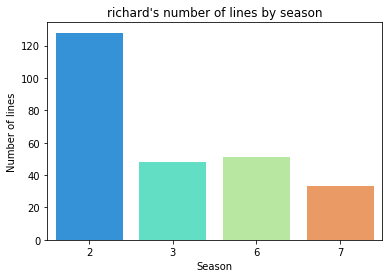

In [37]:
char_lines('richard')

##### Tertiary characters (50 - 100 lines)

In [38]:
tertiary_characters = df.character.value_counts()[(df.character.value_counts().values <= 100) &
                                                 (df.character.value_counts().values > 50)].keys()

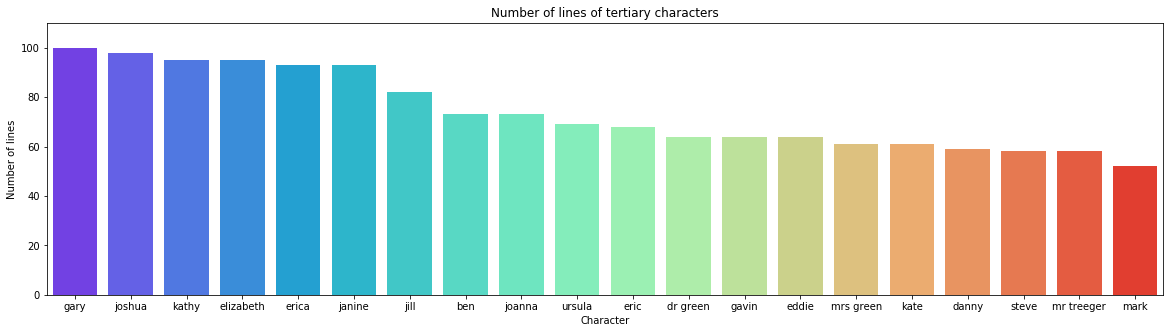

In [39]:
line_count(tertiary_characters, 10, 'tertiary')

Some less relevant relationships including other characters

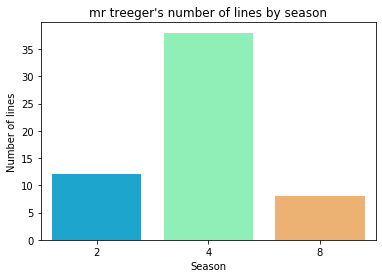

In [40]:
char_lines('mr treeger')

### Networks

In [41]:
main_characters_caps = ['Monica', 'Rachel', 'Chandler', 'Ross', 'Phoebe', 'Joey']

In [42]:
#create three lists. One contains the character talking, the next the name of the main character they have
#have mentioned and finally the number of times they mentioned that person
num = []
char_talking = []
char_talking_about = []
for char in main_characters:
    for c in main_characters_caps:
        char_talking.append(char)
        char_talking_about.append(c)
        num.append(main[(main.character == char) & (main.lines.str.contains(c))].shape[0])

In [43]:
#create a dataframe
network = pd.DataFrame(list(zip(char_talking, char_talking_about, num)), 
                       columns = ['char_talking', 'char_talking_about', 'num'])

In [44]:
network.head()

,char_talking,char_talking_about,num
0,monica,Monica,63
1,monica,Rachel,183
2,monica,Chandler,287
3,monica,Ross,203
4,monica,Phoebe,249


In [45]:
#capitalise character talking so that is graph recognises names as being the same
network ['char_talking'] = network['char_talking'].map(lambda x: x.capitalize())

In [46]:
DG = nx.DiGraph()
network.head()
DG.add_nodes_from(main_characters_caps)
DG.add_weighted_edges_from(network.values)

Rachel and Ross have the strongest relationship (likely as they dates frequently. Rachel and Joey, and Monica and Chandler also have strong relationships. Phoebe and Chandler have the least strong relationship.

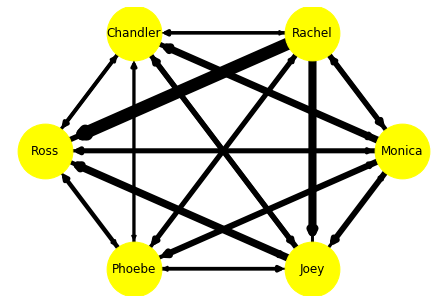

In [47]:
edges = DG.edges()
weights = [DG[u][v]['weight'] for u,v in edges]
weights = [w / 40 for w in weights]
nx.draw(DG, pos=nx.circular_layout(DG), edges = edges, width=weights, with_labels=True, 
        node_size = 3000, node_color = 'yellow')